# Grad-CAM với thư viện pytorch-grad-cam
Notebook này hướng dẫn sử dụng thư viện `pytorch-grad-cam` để trực quan hóa vùng chú ý của mô hình EfficientNet-B3 sau khi phân loại DR.

In [1]:
# Cài đặt thư viện nếu chưa có
!pip install grad-cam

In [2]:
import torch
from torchvision.models import efficientnet_b3
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [3]:
# Load mô hình EfficientNet-B3 đã huấn luyện
NUM_CLASSES = 5
model = efficientnet_b3(weights=None)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
model.load_state_dict(torch.load('dr_best_model.pth', map_location='cpu', weights_only=True))
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [4]:
# Chọn target layer cho Grad-CAM
target_layer = model.features[-1]

In [5]:
# Định nghĩa transform cho ảnh đầu vào
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
def load_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0)
    img_np = np.array(img.resize((224, 224))) / 255.0
    return img_tensor, img_np

In [14]:
# Hiển thị Grad-CAM cho một ảnh
img_path = 't.jpg'  # thay bằng ảnh bạn muốn
img_tensor, img_np = load_image(img_path)
cam = GradCAM(model=model, target_layers=[target_layer])
outputs = model(img_tensor)
pred_class = outputs.argmax().item()
grayscale_cam = cam(input_tensor=img_tensor, targets=[ClassifierOutputTarget(pred_class)])
grayscale_cam = grayscale_cam[0]
visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

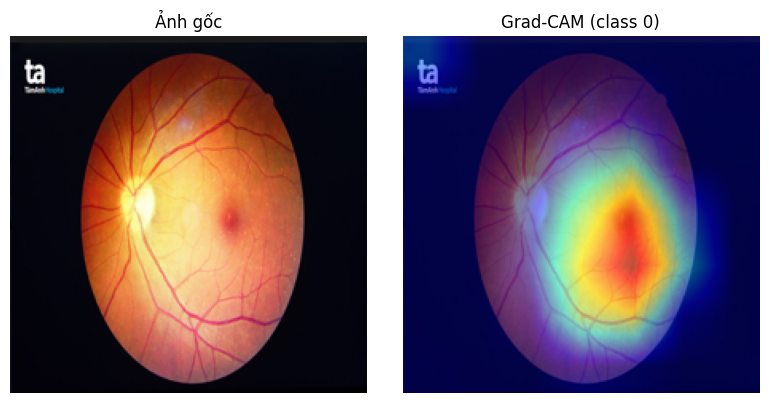

In [15]:
# Hiển thị ảnh gốc và Grad-CAM
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title('Ảnh gốc')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(visualization)
plt.title(f'Grad-CAM (class {pred_class})')
plt.axis('off')
plt.tight_layout()
plt.show()